# In this notebook I'm just gonna manually train 4 different models

In [12]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess_multi_piece import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN
from compression_nn.utils import plot_test_error

import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

# Process data; with ZCA whitening

In [6]:
# no normalization

# train only on OMM and S8
pars_train = pars_train[:, 0:2]
pars_LFI = pars_LFI[:, 0:2]

In [7]:
num_samples = len(pars_train)
# split the sample for training ----------
train_split, val_split = int(0.9*num_samples), int(0.1*num_samples)


# Start Training!

In [8]:
dv_separations = [np.arange(0,160), np.arange(160,320), np.arange(320,576), np.arange(576, 608)]

In [9]:
# Base
config = {
        'test_id': 'piece_v0_',
        'hidden_dims': [64, 64],
        'dropout_rate': 0.2
        }

for i, piece_idx in enumerate(dv_separations):
    if i < 3:
        continue
    print(i)
    
    # Prepare data
    train_loader, val_loader, test_loader, zca = prepare_data_for_training(
        train_x=dv[:train_split][:,piece_idx], #only one statistics
        train_y=pars_train[:train_split],
        val_x=dv[train_split:][:,piece_idx], #only one statistics
        val_y=pars_train[train_split:],
        test_x=dv_LFI[:,piece_idx], #only one statistics
        test_y=pars_LFI,
        batch_size=BATCH_SIZE,
        whitening = True
    )
    
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id']+'pieceIdx_'+str(i),
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act=torch.nn.Softplus()
    )

    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

3


 55%|█████▌    | 166/300 [03:52<05:45,  2.58s/it]

Epoch 166/300:
Training Loss: 0.044641
Validation Loss: 0.039036


 60%|██████    | 181/300 [04:21<02:50,  1.43s/it]

Epoch 181/300:
Training Loss: 0.045038
Validation Loss: 0.038610


 65%|██████▌   | 196/300 [04:49<04:55,  2.84s/it]

Epoch 196/300:
Training Loss: 0.044640
Validation Loss: 0.038919


 70%|███████   | 211/300 [05:20<02:46,  1.87s/it]

Epoch 211/300:
Training Loss: 0.044550
Validation Loss: 0.037963


 74%|███████▍  | 222/300 [05:42<02:00,  1.54s/it]

Early stopping triggered after 223 epochs
Best validation loss is 0.03791310365215458
Model and preprocessing saved to models/model_piece_v0_pieceIdx_3.pkl


# Validate seperately

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.037
 $R^2$ = 0.976
Error S_8 = 10.092


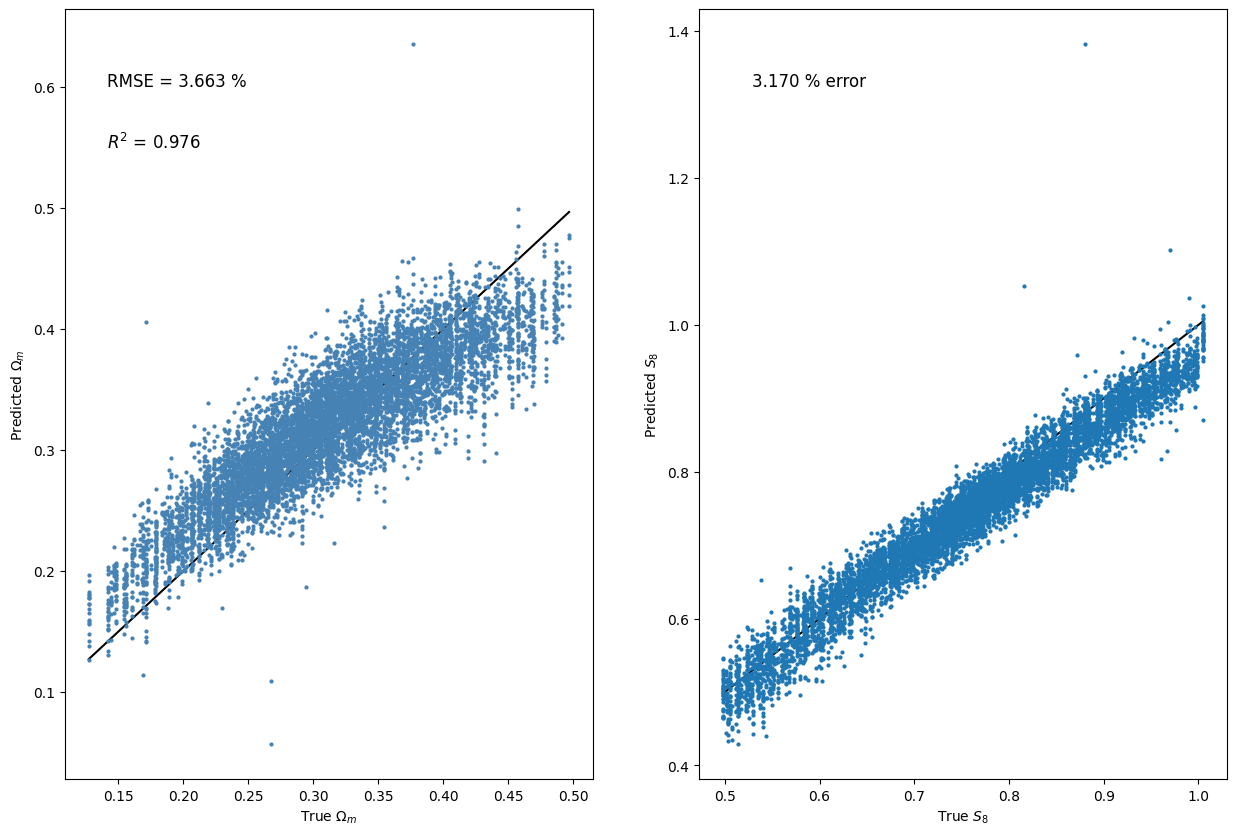

In [23]:
loaded_model = CompressionNN.load('piece_v0_pieceIdx_0')
loaded_model.model.to('cpu')

piece_idx = dv_separations[0]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[:train_split][:,piece_idx], #only one statistics
    train_y=pars_train[:train_split],
    val_x=dv[train_split:][:,piece_idx], #only one statistics
    val_y=pars_train[train_split:],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error(loaded_model, test_loader, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.167
 $R^2$ = 0.505
Error S_8 = 20.886


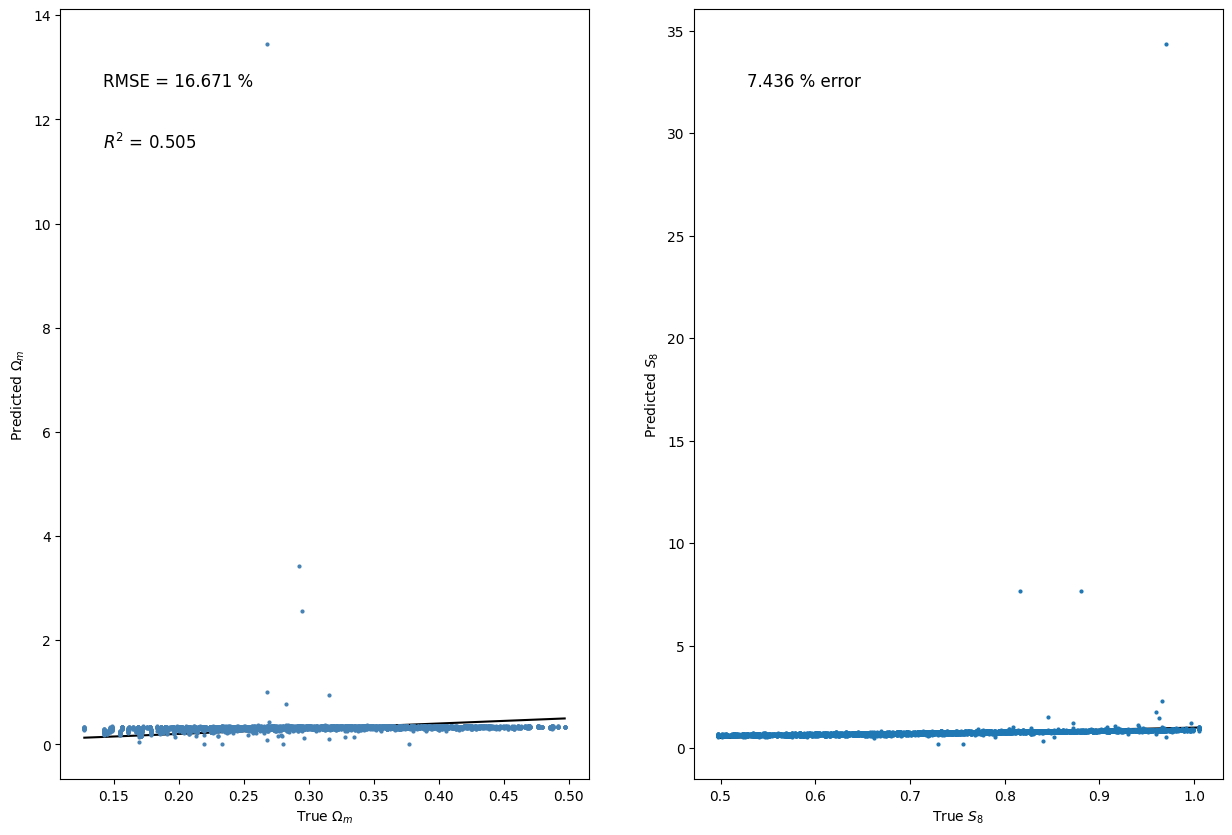

In [14]:
loaded_model = CompressionNN.load('piece_v0_pieceIdx_1')
loaded_model.model.to('cpu')

piece_idx = dv_separations[1]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[:train_split][:,piece_idx], #only one statistics
    train_y=pars_train[:train_split],
    val_x=dv[train_split:][:,piece_idx], #only one statistics
    val_y=pars_train[train_split:],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error(loaded_model, test_loader, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.066
 $R^2$ = 0.921
Error S_8 = 19.120


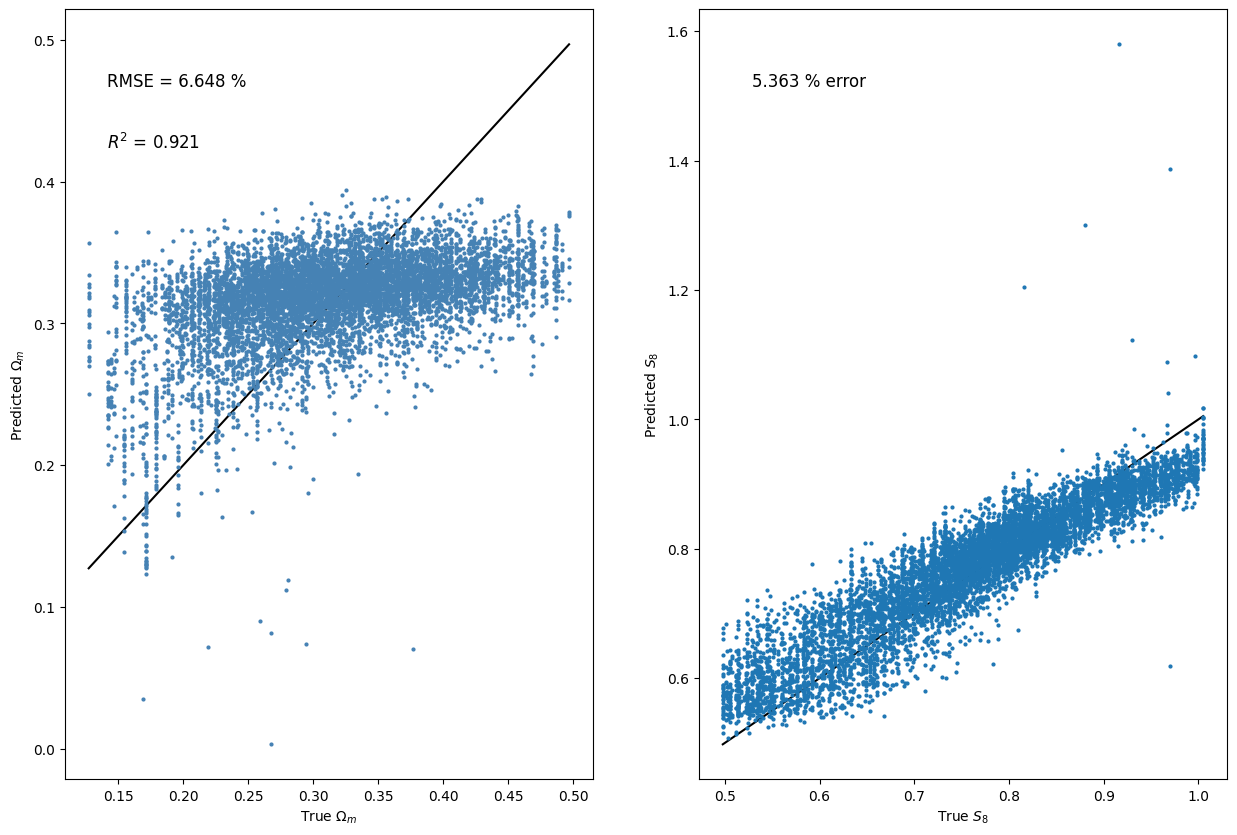

In [15]:
loaded_model = CompressionNN.load('piece_v0_pieceIdx_2')
loaded_model.model.to('cpu')

piece_idx = dv_separations[2]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[:train_split][:,piece_idx], #only one statistics
    train_y=pars_train[:train_split],
    val_x=dv[train_split:][:,piece_idx], #only one statistics
    val_y=pars_train[train_split:],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error(loaded_model, test_loader, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.053
 $R^2$ = 0.949
Error S_8 = 13.868


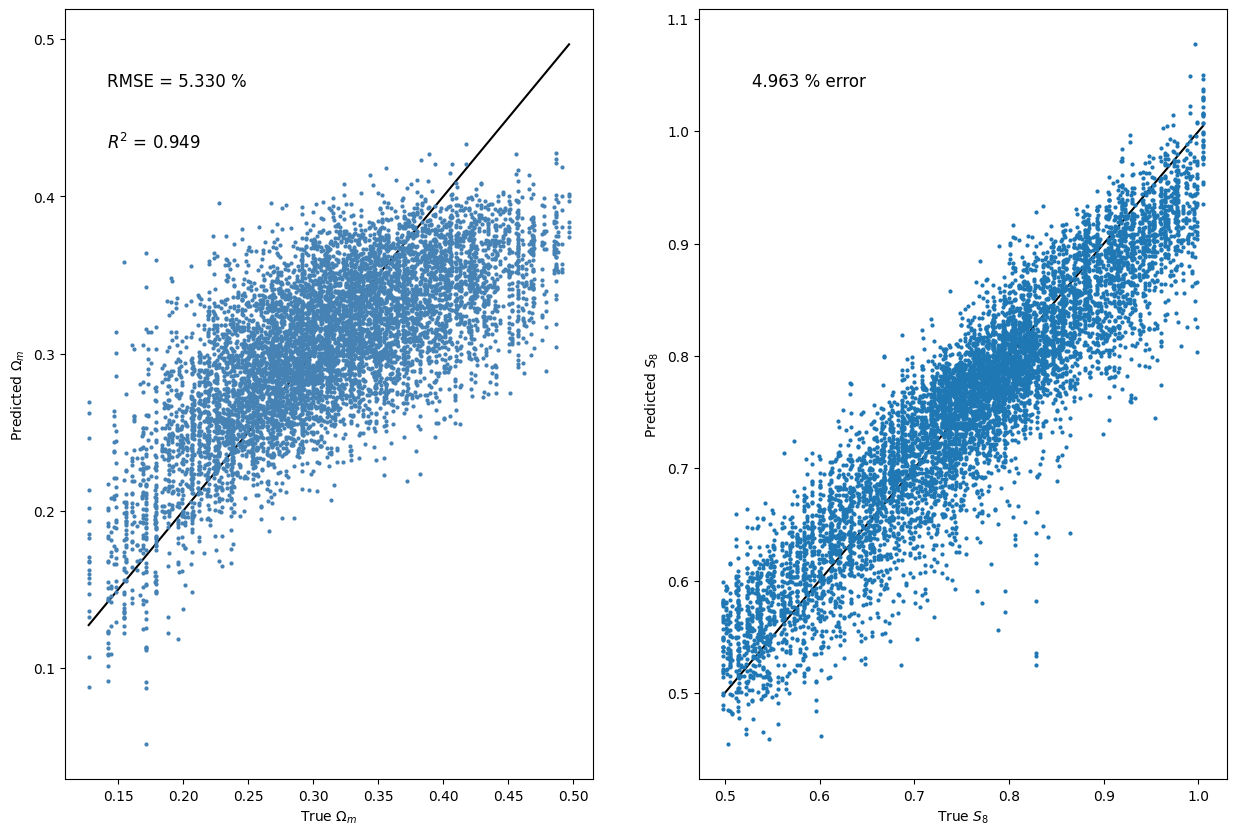

In [16]:
loaded_model = CompressionNN.load('piece_v0_pieceIdx_3')
loaded_model.model.to('cpu')

piece_idx = dv_separations[3]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[:train_split][:,piece_idx], #only one statistics
    train_y=pars_train[:train_split],
    val_x=dv[train_split:][:,piece_idx], #only one statistics
    val_y=pars_train[train_split:],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error(loaded_model, test_loader, device='cpu', output=True)


# Validate together

In [67]:
def plot_test_error_list_models_avg(model_list, test_loader_list, device='cuda', output=False, out_name='test', Y_min=0, Y_max=1, color='steelblue'):

    g=[0, 1]
    
    n_models = len(model_list)

    

    ## Model performance metrics on test set
    num_maps=test_loader.dataset.tensors[0].shape[0]

    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    
    params_NN_tmp   = np.zeros((n_models, num_maps,len(g)), dtype=np.float32)

    for jj in range(n_models):
        points = 0
        # model.eval()
        model = model_list[jj]
        for x, y in test_loader_list[jj]:
            with torch.no_grad():
                bs    = x.shape[0]         #batch size
                if x.dtype == torch.float64:
                    x = x.float()
                x     = x.to(device)       #send data to device
                y     = y.to(device)  #send data to device
                p     = model.predict(x)           #prediction for mean and variance
                y_NN  = p           #prediction for mean

                # save results to their corresponding arrays
                if jj==0:
                    params_true[points:points+x.shape[0]] = y.cpu().numpy() 
                if isinstance(y_NN, torch.Tensor):
                    y_NN = y_NN.cpu().numpy()
                params_NN_tmp[jj, points:points+x.shape[0]]   = y_NN

                points    += x.shape[0]
    params_NN = np.mean(params_NN_tmp, axis=0)       
    # normalization if needed
    params_true = params_true * (Y_max - Y_min) + Y_min
    params_NN   = params_NN   * (Y_max - Y_min) + Y_min
    
    test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
    
    RMSE = np.sqrt(np.mean((params_true - params_NN)**2,axis=0))
    RMSE_P = RMSE*100
    params_true_mean = np.mean(params_true)
    tmp = np.mean((params_true - params_true_mean)**2, axis=0)
    R2 = 1 - (RMSE)**2 / tmp
    # print('Error Omega_m = %.3f'%test_error[0])
    print(r' RMSE = %.3f'%RMSE[0])
    print(r' $R^2$ = %.3f'%R2[0])
    print('Error S_8 = %.3f'%test_error[0])


    f, axarr = plt.subplots(1, 2, figsize=(15,10))
    axarr[0].plot(np.linspace(min(params_true[:,0]),max(params_true[:,0]),100),np.linspace(min(params_true[:,0]),max(params_true[:,0]),100),color="black")

    axarr[0].plot(params_true[:,0],params_NN[:,0],marker="o",ls="none",markersize=2, color=color)
    axarr[0].set_xlabel(r"True $\Omega_m$")
    axarr[0].set_ylabel(r"Predicted $\Omega_m$")
    # axarr.text(0.1,0.9,"%.3f %% error" % test_error[0],fontsize=12,transform=axarr.transAxes)
    
    axarr[0].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[0],fontsize=12,transform=axarr[0].transAxes)
    axarr[0].text(0.08,0.82,r"$R^2$ = %.3f" % R2[0],fontsize=12,transform=axarr[0].transAxes)
    
    
    axarr[1].plot(np.linspace(min(params_true[:,1]),max(params_true[:,1]),100),np.linspace(min(params_true[:,1]),max(params_true[:,1]),100),color="black")
    axarr[1].plot(params_true[:,1],params_NN[:,1],marker="o",ls="none",markersize=2, color=color)
    axarr[1].set_xlabel(r"True $S_8$")
    axarr[1].set_ylabel(r"Predicted $S_8$")
    axarr[1].text(0.1,0.9,"%.3f %% error" % test_error[1],fontsize=12,transform=axarr[1].transAxes)

    if output:
        f.savefig('./output/'+out_name+'.pdf', dpi=300, format='pdf')

        # Also save for LFI later
        info = dict()
        info['params'] = params_true
        info['compressed_DV'] = params_NN
        np.save('./output/'+out_name+'_compressed_dv',info)

In [68]:
model_list = []
test_loader_list = []
for i in range(len(dv_separations)):
    loaded_model = CompressionNN.load('piece_v0_pieceIdx_'+str(i))
    loaded_model.model.to('cpu')
    model_list.append(loaded_model)
    
    piece_idx = dv_separations[i]

    # Prepare data
    train_loader, val_loader, test_loader, zca = prepare_data_for_training(
        train_x=dv[:train_split][:,piece_idx], #only one statistics
        train_y=pars_train[:train_split],
        val_x=dv[train_split:][:,piece_idx], #only one statistics
        val_y=pars_train[train_split:],
        test_x=dv_LFI[:,piece_idx], #only one statistics
        test_y=pars_LFI,
        batch_size=BATCH_SIZE,
        whitening = True
    )
    
    
    test_loader_list.append(test_loader)

 RMSE = 0.062
 $R^2$ = 0.931
Error S_8 = 14.578


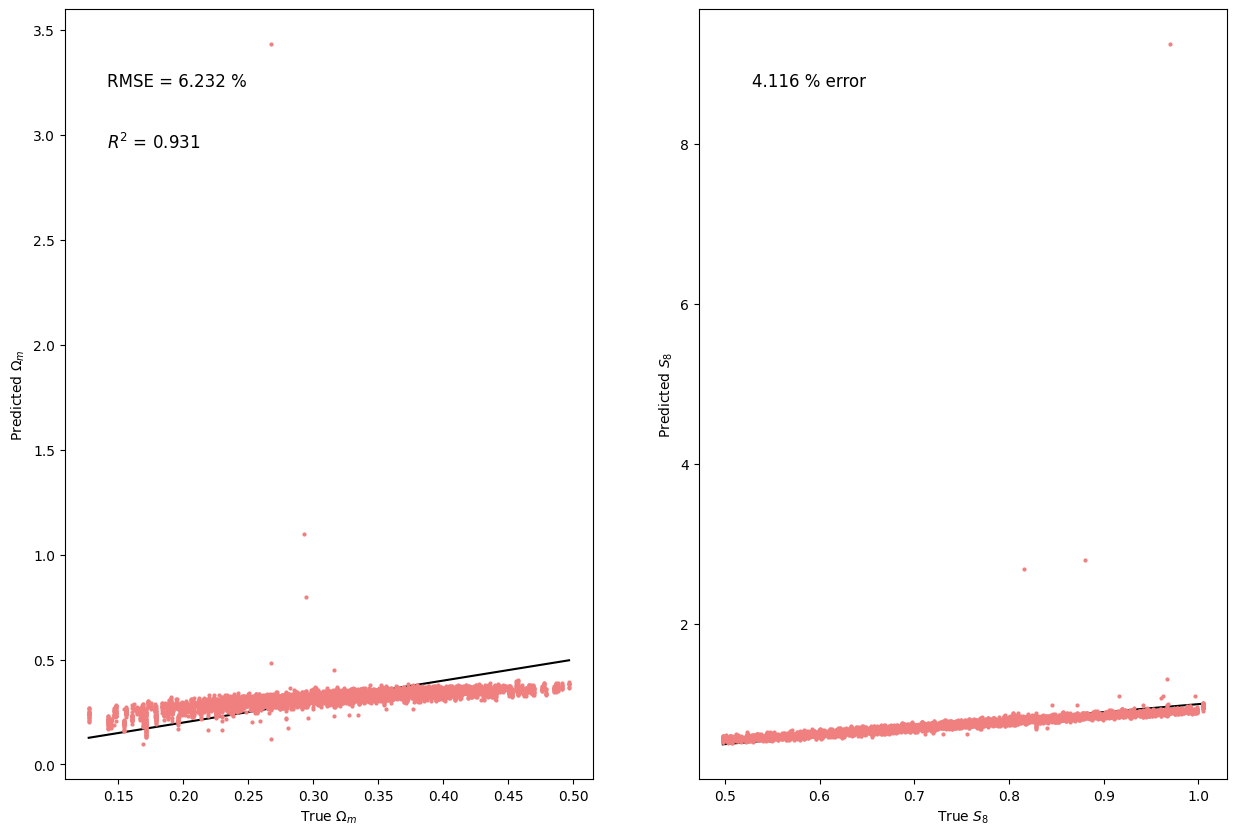

In [69]:
plot_test_error_list_models_avg(model_list, test_loader_list, device='cpu', output=False, out_name='test', Y_min=0, Y_max=1, color='lightcoral')
